In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import basename, dirname
from shutil import copyfile

import json
import pickle
from collections import OrderedDict

import torch

In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns

In [4]:
import numpy as np

In [5]:
os.chdir("..")

In [21]:
from da.clust_utils import cramers_corrected_stat, flatten_dict, kmeans_train, kmeans_predict

In [7]:
np.random.seed(21)

# Train k-means

In [34]:
model_name  = 'concat60'
savedir = f"experiments/en_et_{model_name}/internals-docs"

# Train k-means on sentence embeddings

In [38]:
sent_enc_path = f"{savedir}/sent_means_train.pkl"

In [39]:
%%time

with open(sent_enc_path, 'rb') as f:
    data_encoded = pickle.load(f)
    
NUM_CLUSTERS=4

kmeans_sent = kmeans_train(data_encoded, NUM_CLUSTERS)

if not os.path.isdir(savedir):
    os.mkdir(savedir)

fn = f"{savedir}/kmeans_train_sent.pkl"
print(f"Saving to {fn}")
with open(fn, 'wb') as f:
    pickle.dump(kmeans_sent, f)

Saving to experiments/en_et_concat60/internals-docs/kmeans_train_sent.pkl
CPU times: user 8min 32s, sys: 1.69 s, total: 8min 34s
Wall time: 1min 20s


# Train k-means on document embeddings

In [36]:
doc_enc_path = f"{savedir}/doc_encoded_train.pkl"

In [37]:
%%time

with open(doc_enc_path, 'rb') as f:
    data_encoded = pickle.load(f)
    
NUM_CLUSTERS=4

kmeans_docs = kmeans_train(data_encoded, NUM_CLUSTERS)

if not os.path.isdir(savedir):
    os.mkdir(savedir)

fn = f"{savedir}/kmeans_train_doc.pkl"
print(f"Saving to {fn}")
with open(fn, 'wb') as f:
    pickle.dump(kmeans_docs, f)

Saving to experiments/en_et_concat60/internals-docs/kmeans_train_doc.pkl
CPU times: user 6min 5s, sys: 771 ms, total: 6min 6s
Wall time: 1min


# Predict

In [14]:
with open(f"{savedir}/kmeans_train.pkl", 'rb') as f:
    kmeans = pickle.load(f)

In [15]:
model_name  = 'concat60'
savedir = f"experiments/en_et_{model_name}/nmt-clusters-sent"
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [18]:
import matplotlib.pyplot as plt

Corr k: 0.6948180356871073
col_0              0       1       2       3
row_0                                       
EMEA           87476    4999    5172  312893
Europarl        6680  446613   44640    2233
JRC-Acquis     98987  370022    5045   25966
OpenSubtitles  59508   13907  426241    1220


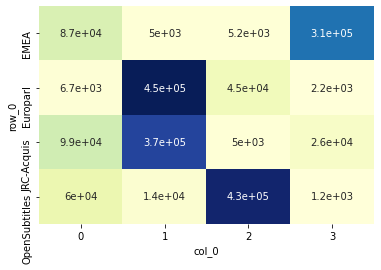

Corr k: 0.741079470183595
col_0            0     1     2     3
row_0                               
EMEA           304    53    48  2943
Europarl         5  3470   235     6
JRC-Acquis     151  2715    38   101
OpenSubtitles  151    91  2798     4


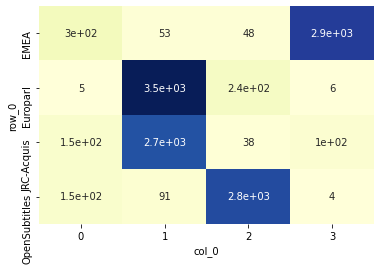

Corr k: 0.7339679418290467
col_0            0     1     2     3
row_0                               
EMEA           262    69    30  2954
Europarl        10  2810   264    23
JRC-Acquis      89  2940    29   132
OpenSubtitles  126   132  2821     6


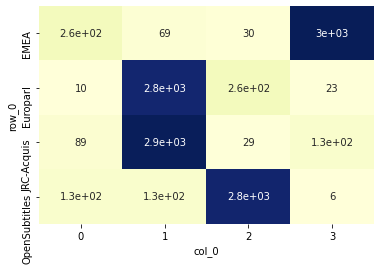

In [19]:
for split in ['train', 'dev-cl', 'test-cl']:
    fn = f"experiments/en_et_{model_name}/internals-docs/sent_means_{split}.pkl"
    with open(fn, 'rb') as f:
        data_encoded = pickle.load(f)
    
    labels_hat, labels_true = kmeans_predict(kmeans, data_encoded, split=='train')
    
    conf_matrix = pd.crosstab(labels_true, labels_hat)
    corr_k = cramers_corrected_stat(conf_matrix)

    print(f"Corr k: {corr_k}")
    print(conf_matrix)
    
    i = 0
    for domain_name, v in data_encoded.items():
        fn = f"{domain_name}.{split}.clust.nmt.sent"
        np.savetxt(f"{savedir}/{fn}", labels_hat[i:i+len(v)].astype(int), fmt="%i")
        i += len(v)

    sns.heatmap(conf_matrix,
                cmap="YlGnBu", annot=True, cbar=False)
    plt.show()

# Bert sent clusters

In [10]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_sent_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [11]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [12]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.24168047830449288
col_0               0       1      2       3
row_0                                       
EMEA            72707  140991  39598  157244
Europarl       166334  177192  56586  100054
JRC-Acquis     162534  163134  29920  144432
OpenSubtitles   46245   50394  84391  319846


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

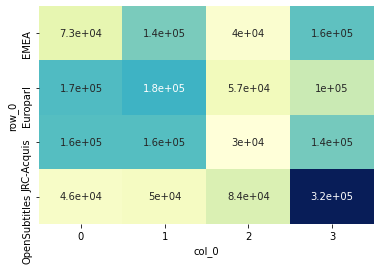

In [13]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Bert doc clusters

In [14]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]

In [15]:
labels_bert_all = []
labels_bert_all_true = []
for k,v in labels_bert.items():
    labels_bert_all.extend(v)
    labels_bert_all_true.extend([k] * len(v))

In [16]:
conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.8089680719230101
col_0               0       1       2       3
row_0                                        
EMEA            42870  344373    3200   20097
Europarl          521    3372  493821    2452
JRC-Acquis     279334  152902   61959    5825
OpenSubtitles    1001    9881     899  489095


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

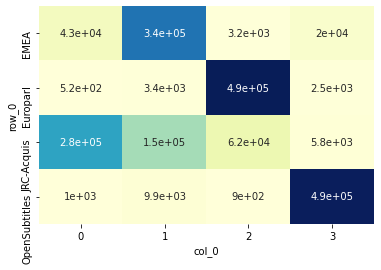

In [17]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

# Rand clusters

In [18]:
from random import sample

In [19]:
labels_rand = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust-new/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_rand[domain_name] = [sample([0,1,2,3], 1)[0] for l in f.readlines()]

In [20]:
labels_rand_all = []
labels_rand_all_true = []
for k,v in labels_rand.items():
    labels_rand_all.extend(v)
    labels_rand_all_true.extend([k] * len(v))

In [21]:
conf_matrix = pd.crosstab(np.array(labels_rand_all_true), np.array(labels_rand_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)

0.0
col_0               0       1       2       3
row_0                                        
EMEA           102320  102765  102762  102693
Europarl       124741  124613  125804  125008
JRC-Acquis     125047  125288  124874  124811
OpenSubtitles  125142  125495  124959  125280


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

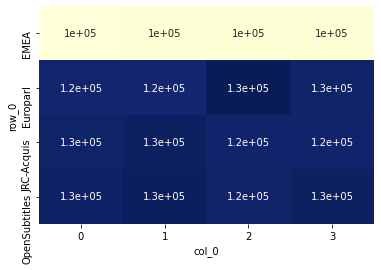

In [22]:
sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

In [23]:
i = 0
for k,v in data_raw.items():
    fn = f"rand_labels-{k}.txt"
    np.savetxt(f"{savedir}/{fn}", np.array(labels_rand_all)[i:i+len(v)].astype(int), fmt="%i")
    i += len(v)

NameError: name 'data_raw' is not defined